# STV DPD for T cell data

## Requirements

Python 3.10+

## STV and DPD calculation

Goal: separate Responder from Non-Responder cells and run SVM to get STV and DPD scores

### Data source:

- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120575

- Sade-Feldman, M., Yizhak, K., Bjorgaard, S. L., Ray, J. J., De Boer, C. G., Jenkins, R. W., Lieb, D., Chen, J., Frederick, D. T., Barzily-Rokni, M., Freeman, S. S., Reuben, A., Hoover, P., Villani, A. C., Ivanova, E., Portell, A., Lizotte, P. H., Aref, A. R., Eliane, J. P., . . . Hacohen, N. (2018). Defining T Cell States Associated with Response to Checkpoint Immunotherapy in Melanoma. Cell, 175(4), 998-1013.e20. https://doi.org/10.1016/j.cell.2018.10.038

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
#from cmapPy.pandasGEXpress.parse import parse

import pickle
import pylab as plt
import statistics
import scipy.stats
import csv
import matplotlib
#import cstarpy

In [34]:
# os.makedirs("Immune Cells Output", exist_ok = True)

Load metadata

In [35]:
dat_ID = pd.read_csv('T Cells/GSE120575_patient_ID_single_cells.txt/GSE120575_patient_ID_single_cells.csv')
dat_ID

,Sample name,title,source name,organism,characteristics: patinet ID (Pre=baseline; Post= on treatment),characteristics: response,characteristics: therapy,molecule,description,processed data file,raw file
0,Sample 1,A10_P3_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,NaN,NaN,NaN,NaN
1,Sample 2,A11_P1_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,NaN,NaN,NaN,NaN
2,Sample 3,A11_P3_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,NaN,NaN,NaN,NaN
3,Sample 4,A11_P4_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,NaN,NaN,NaN,NaN
4,Sample 5,A12_P3_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16286,Sample 16287,H5_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,NaN,NaN,NaN,NaN
16287,Sample 16288,H6_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,NaN,NaN,NaN,NaN
16288,Sample 16289,H7_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,NaN,NaN,NaN,NaN
16289,Sample 16290,H8_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,NaN,NaN,NaN,NaN


### 1.1. Loading the data <br> 1.1a: Method 1
Load the whole dataset, then partition into groups. Useful for creating many subgroups, but the initial loading procedure takes a long time.

In [5]:
#data = pd.read_csv('T Cells/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt', index_col=1, header= [0,1], sep='\t')
dat = pd.read_csv('/Users/lidiayung/PhD_project/project_UCD_blca/blca_DATA/blca_DATA_LINCS_output/00_outputs_2020_BC3C/Data_mean_2020_BC3C.csv', na_filter=False)

In [7]:
dat.rename(columns ={'Unnamed: 0':'GENE'}, inplace=True)
dat = dat.set_index("GENE")

In [8]:
dat

,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
GENE,,,,,,,,,,,,,,,,,,,,,
ASG002_BC3C_24H:A03,10.023100,9.346951,5.72340,10.3650,8.990900,8.312100,6.592101,9.71080,7.120000,8.44020,...,11.267300,7.582200,8.74100,11.2911,7.20375,10.037300,7.803650,6.081000,5.76420,9.15840
ASG002_BC3C_24H:A04,9.948600,9.084700,5.80250,10.4846,8.729750,8.499600,6.876300,9.74865,6.973950,8.69105,...,10.159000,6.999300,8.87590,11.4691,7.06050,10.941600,7.608800,6.077100,5.27185,8.12155
ASG002_BC3C_24H:A05,10.032400,9.320600,5.47350,12.1808,9.012300,8.445200,6.822900,9.85920,6.305900,8.52940,...,10.950200,6.859900,8.63190,11.4417,6.78555,11.167601,7.660450,6.021800,5.80860,7.97930
ASG002_BC3C_24H:A06,10.247800,9.444600,5.53365,10.5281,9.084499,8.848800,6.839200,9.95280,6.060450,8.41390,...,10.115500,6.859099,8.82570,11.6000,6.34770,13.660300,7.425950,6.038600,5.60720,9.21290
ASG002_BC3C_24H:J13,10.418800,9.582900,5.77290,10.5666,9.084700,8.947500,6.474100,9.62770,7.197701,4.09710,...,10.405700,7.210200,8.61860,11.4281,6.85070,10.296700,7.632550,6.173400,5.52770,9.07910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,10.248450,8.937100,5.31530,10.4718,8.423300,9.797500,7.554499,9.36855,6.649700,8.25515,...,8.983900,6.264150,9.03680,10.4415,6.20220,9.840500,8.130500,6.234500,8.38820,8.71640
MOAR012_BC3C_24H:P21,9.773100,8.771700,6.14895,9.5793,8.829900,9.830151,7.382050,9.42820,7.091200,8.96030,...,8.931800,7.020500,8.51840,10.2559,6.08185,9.387300,7.949100,6.858600,6.40720,8.99320
MOAR012_BC3C_24H:P22,10.250000,8.784149,6.26280,10.2827,8.045100,9.741400,6.802450,9.14075,6.602900,9.45850,...,10.710000,6.848500,8.62490,10.0711,6.16590,10.797000,8.187600,6.531800,6.08810,9.02060


Select Responders and Non-responders

In [39]:
IDs_R = dat_ID[np.logical_and(dat_ID["characteristics: response"] == "Responder" , dat_ID["characteristics: patinet ID (Pre=baseline; Post= on treatment)"].str.contains("Post"))]["title"]
IDs_other = dat_ID[np.logical_and(dat_ID["characteristics: response"] == "Responder" , dat_ID["characteristics: patinet ID (Pre=baseline; Post= on treatment)"].str.contains("Pre"))]["title"]
# IDs_R = IDs_R.tolist()
# IDs_R = ["GENE"] + IDs_R
IDs_base = dat_ID[dat_ID["characteristics: patinet ID (Pre=baseline; Post= on treatment)"].str.contains("Pre")]["title"]
IDs_treat = dat_ID[dat_ID["characteristics: patinet ID (Pre=baseline; Post= on treatment)"].str.contains("Post")]["title"]

IDs_NR = dat_ID[np.logical_and(dat_ID["characteristics: response"] == "Non-responder" , dat_ID["characteristics: patinet ID (Pre=baseline; Post= on treatment)"].str.contains("Post"))]["title"]
IDs_other1 = dat_ID[np.logical_and(dat_ID["characteristics: response"] == "Non-responder" , dat_ID["characteristics: patinet ID (Pre=baseline; Post= on treatment)"].str.contains("Pre"))]["title"]
# IDs_NR = IDs_NR.tolist()
# IDs_NR = ["GENE"] + IDs_NR

IDs_total = dat_ID["title"]
# IDs_total = IDs_total.tolist()
# IDs_total = ["GENE"] + IDs_total

In [40]:
display(len(IDs_R) + len(IDs_NR) + len(IDs_other) + len(IDs_other1) == len(IDs_total))

True

In [41]:
dat_R = dat[dat.columns[dat.columns.isin(IDs_R)]]
dat_R

,A10_P1_M15,A10_P4_M15,A10_P5_M15,A10_P6_M15,A11_P1_M15,A11_P2_M15,A11_P5_M15,A11_P6_M15,A12_P1_M15,A12_P2_M15,...,H12_P8_MMD5_T_enriched,H1_P8_MMD5_T_enriched,H2_P8_MMD5_T_enriched,H3_P8_MMD5_T_enriched,H4_P8_MMD5_T_enriched,H5_P8_MMD5_T_enriched,H6_P8_MMD5_T_enriched,H7_P8_MMD5_T_enriched,H8_P8_MMD5_T_enriched,H9_P8_MMD5_T_enriched
GENE,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
TNMD,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
DPM1,8.41,7.76,8.45,0.0,0.00,0.0,0.0,8.79,0.0,8.41,...,0.0,0.0,8.65,0.0,0.0,0.0,0.0,0.0,0.0,0.00
SCYL3,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
C1orf112,0.00,0.00,0.00,0.0,3.18,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,5.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-621B10.8,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
RP11-114I8.4,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
RP11-180C16.1,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [42]:
dat_NR = dat[dat.columns[dat.columns.isin(IDs_NR)]]
dat_NR

,A10_P1_M55_L001,A10_P2_M55_L001,A10_P3_M55_L001,A10_P4_M55_L001,A11_P1_M55_L001,A11_P2_M55_L001,A11_P3_M55_L001,A11_P4_M55_L001,A12_P1_M55_L001,A12_P2_M55_L001,...,H12_P5_M67_L001_T_enriched,H1_P5_M67_L001_T_enriched,H2_P5_M67_L001_T_enriched,H3_P5_M67_L001_T_enriched,H4_P5_M67_L001_T_enriched,H5_P5_M67_L001_T_enriched,H6_P5_M67_L001_T_enriched,H7_P5_M67_L001_T_enriched,H8_P5_M67_L001_T_enriched,H9_P5_M67_L001_T_enriched
GENE,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0
TNMD,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0
DPM1,7.41,0.0,9.12,0.0,0.0,1.87,0.0,0.0,0.0,0.0,...,0.0,6.60,0.00,0.0,0.00,7.34,0.0,0.0,0.0,0.0
SCYL3,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1.9,0.0,...,0.0,5.15,2.54,0.0,0.00,0.00,0.0,0.0,0.0,0.0
C1orf112,3.77,0.0,0.00,0.0,0.0,0.00,0.0,0.0,5.7,0.0,...,0.0,8.03,0.00,0.0,0.61,7.65,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-621B10.8,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0
RP11-114I8.4,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0
RP11-180C16.1,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0


In [43]:
dat_R_base = dat[dat.columns[dat.columns.isin(IDs_other)]]
dat_R_base

,A10_P3_M11,A11_P1_M11,A11_P3_M11,A11_P4_M11,A12_P3_M11,A12_P6_M11,A2_P1_M11,A2_P4_M11,A3_P1_M11,A3_P3_M11,...,H5_P3_M41_L001,H6_P2_M41_L001,H6_P3_M41_L001,H7_P1_M41_L001,H7_P3_M41_L001,H8_P1_M41_L001,H8_P2_M41_L001,H8_P3_M41_L001,H9_P1_M41_L001,H9_P3_M41_L001
GENE,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
TNMD,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
DPM1,0.0,9.24,0.0,7.99,0.0,0.0,0.0,0.0,8.44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
SCYL3,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,6.15,0.0,0.0,0.0,0.0
C1orf112,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-621B10.8,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
RP11-114I8.4,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
RP11-180C16.1,0.0,0.00,0.0,0.00,0.0,1.1,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [44]:
dat_NR_base = dat[dat.columns[dat.columns.isin(IDs_other1)]]
dat_NR_base

,A10_P1_M34,A10_P2_M34,A10_P3_M34,A10_P4_M34,A11_P1_M34,A11_P2_M34,A11_P3_M34,A11_P4_M34,A12_P1_M34,A12_P2_M34,...,H7_P2_M77_L001,H7_P3_M77_L001,H8_P1_M77_L001,H8_P2_M77_L001,H8_P3_M77_L001,H8_P4_M77_L001,H9_P1_M77_L001,H9_P2_M77_L001,H9_P3_M77_L001,H9_P4_M77_L001
GENE,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
TNMD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
DPM1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.65,0.0,0.0,0.0,0.0,0.0
SCYL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,8.0
C1orf112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.87,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-621B10.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
RP11-114I8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
RP11-180C16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


### 1.2. Transpose the dataframe to accord with svm requirements
Rows must be cell IDs, with the transcripts in the columns.

In [45]:
tdat = dat.transpose()
tdat.index.name = "ID"

## 2. CD8 and CD4 subgroups
Filter for CD8+ and CD4+ T cells.
1. Filter for CD3 expression (T cell marker)
2. Filter for CD4 or CD8 expression

### 2.1 Plot cells expressing CD4 and/or CD8

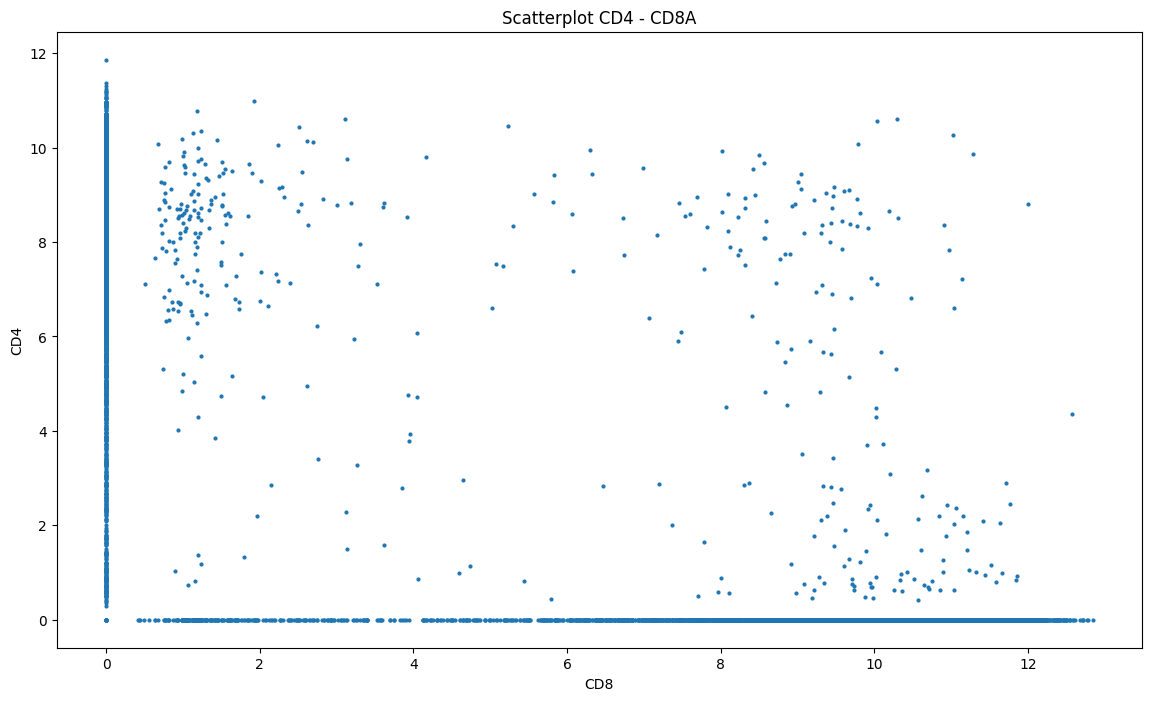

In [46]:
# import matplotlib

plt.figure(figsize=(14,8))
plt.scatter(tdat["CD8A"], tdat["CD4"], s = 4)

plt.xlabel("CD8")
plt.ylabel("CD4")
plt.title("Scatterplot CD4 - CD8A")

plt.show()

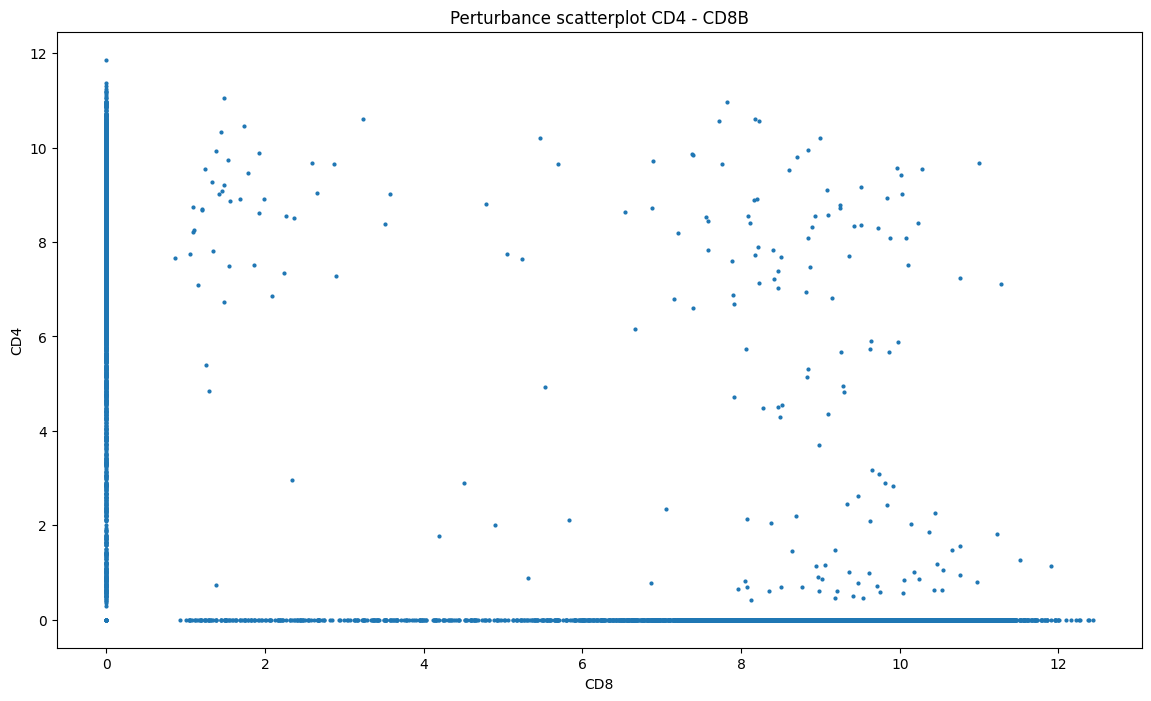

In [47]:
# import matplotlib

plt.figure(figsize=(14,8))
plt.scatter(tdat["CD8B"], tdat["CD4"], s = 4)

plt.xlabel("CD8")
plt.ylabel("CD4")
plt.title("Perturbance scatterplot CD4 - CD8B")

plt.show()

While most cells express either CD4 or CD8, there are also cells which express both. These should be disregarded for the T-cell type-specific STV conditions.

### 2.2 Filter for specific T cells

In [48]:
filter_0 = dat.columns[(dat.loc["CD3D"] != 0) | (dat.loc["CD3E"] != 0) | (dat.loc["CD3G"] != 0)]

Calculate number of cells with <br>
- no CD4 but CD8 <br>
- no CD8 but CD4 <br>
- both <br>
- neither

In [49]:
filter1 = list(set(filter_0).intersection(set(dat.columns[(dat.loc['CD4'] == 0) & ((dat.loc['CD8A'] != 0) | (dat.loc['CD8B'] != 0))])))
#dat_filtered1 = dat[filter1]

filter2 = list(set(filter_0).intersection(set(dat.columns[(dat.loc['CD4'] != 0) & (dat.loc['CD8A'] == 0) & (dat.loc['CD8B'] == 0)])))
#dat_filtered2 = dat[filter2]

filter3 = list(set(filter_0).intersection(set(dat.columns[(dat.loc['CD4'] != 0) & ((dat.loc['CD8A'] != 0) | (dat.loc['CD8B'] != 0))])))
#dat_filtered3 = dat[filter3]

filter4 = list(set(filter_0).intersection(set(dat.columns[(dat.loc['CD4'] == 0) & (dat.loc['CD8A'] == 0) & (dat.loc['CD8B'] == 0)])))
#dat_filtered4 = dat[filter4]

print(str(len(filter1)) + "\n" + str(len(filter2)) + "\n" + str(len(filter3)) + "\n" + str(len(filter4)))


6713
2828
405
2680


### 4.1. General dataspace (not limited to L1000 genes)
con1: Responders and Non-responders on-treatment <br>
con2: Responders and Non-responders pre-treatment <br>
con3: con1 with CD4 = 0 and CD8 > 0 <br>
con4: con2 with CD4 = 0 and CD8 > 0 <br>
con5: con1 with CD4 > 0 and CD8 = 0 <br>
con6: con2 with CD4 > 0 and CD8 = 0 <br>

In [50]:
# filter1a = list(set(filter1).intersection(set(IDs_R)))
# filter1b = list(set(filter1).intersection(set(IDs_NR)))
dat_R_con3 = dat_R[list(set(filter1).intersection(set(IDs_R)))]
dat_NR_con3 = dat_NR[list(set(filter1).intersection(set(IDs_NR)))]

# filter1c = list(set(filter1).intersection(set(IDs_other)))
# filter1d = list(set(filter1).intersection(set(IDs_other1)))
dat_R_con4 = dat_R_base[list(set(filter1).intersection(set(IDs_other)))]
dat_NR_con4 = dat_NR_base[list(set(filter1).intersection(set(IDs_other1)))]

# filter2a = list(set(filter2).intersection(set(IDs_R)))
# filter2b = list(set(filter2).intersection(set(IDs_NR)))
dat_R_con5 = dat_R[list(set(filter2).intersection(set(IDs_R)))]
dat_NR_con5 = dat_NR[list(set(filter2).intersection(set(IDs_NR)))]

# filter2c = list(set(filter2).intersection(set(IDs_other)))
# filter2d = list(set(filter2).intersection(set(IDs_other1)))
dat_R_con6 = dat_R_base[list(set(filter2).intersection(set(IDs_other)))]
dat_NR_con6 = dat_NR_base[list(set(filter2).intersection(set(IDs_other1)))]

### 4.2. L1000 dataspace
con1: Responders and Non-responders on-treatment <br>
con2: Responders and Non-responders pre-treatment <br>
con3: con1 with CD4 = 0 and CD8 > 0 <br>
con4: con2 with CD4 = 0 and CD8 > 0 <br>
con5: con1 with CD4 > 0 and CD8 = 0 <br>
con6: con2 with CD4 > 0 and CD8 = 0 <br>

4.2.1. Read L1000 metadata landmark genes and filter current dataset for these genes under conditions 1-6

In [51]:
data_dir = os.path.join("DATA_LINCS")
data_file = os.path.join(data_dir, "info", "geneinfo_beta.txt")
gene_info_df = pd.read_csv(data_file, sep = "\t", index_col = 1)
landmark_gene_symbols = gene_info_df[gene_info_df.feature_space == "landmark"].index.tolist()

In [52]:
gene_list = list(dat_R.index)
np.savetxt("Immune Cells Output/gene_list.csv",
        gene_list,
        delimiter =", ",
        fmt ='% s')

In [53]:
gene_intersect = list(set(gene_list).intersection(set(landmark_gene_symbols)))

### Jing Calculate pathway coefficients

In [4]:
bmra_path = "/Users/lidiayung/Downloads/OneDrive_1_18-07-2024/02_outputs_2020_BC3C"

a_coeff = pd.read_csv(os.path.join(bmra_path, "a_coeffs.csv"), index_col = 0, header = 0)
a_coeff

,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
Androgen,8.520468e-07,0.000007,-0.000015,-3.715240e-05,-0.000002,0.000010,-0.000035,-0.000009,9.856215e-06,0.000011,...,0.000005,4.876247e-06,9.542248e-07,0.000039,-9.443082e-06,2.407120e-05,2.792300e-05,0.000026,0.000020,-1.426797e-05
CDK1,-8.485645e-07,0.000025,-0.000018,3.231122e-06,0.000009,0.000012,-0.000009,-0.000013,-1.148575e-05,0.000005,...,-0.000011,-3.294237e-05,-1.127690e-05,-0.000006,1.858586e-05,-4.435310e-07,-8.044734e-06,0.000011,-0.000010,-1.638872e-05
CDK2,-2.785757e-05,-0.000026,-0.000003,1.161988e-05,-0.000007,0.000012,0.000042,-0.000005,-4.468733e-07,-0.000024,...,-0.000011,3.417854e-06,-3.645115e-05,-0.000009,-3.652259e-07,-5.950117e-06,6.683084e-06,0.000008,0.000015,-9.691141e-06
CDK4_6,8.104772e-06,0.000018,0.000029,2.851324e-06,0.000005,-0.000002,-0.000034,-0.000006,3.000870e-06,0.000006,...,-0.000009,-5.479025e-06,8.259027e-06,0.000011,9.694825e-06,-1.125465e-05,-9.750250e-07,-0.000017,-0.000020,2.527603e-06
EGFR,-6.231848e-05,-0.000004,0.000027,2.492636e-05,-0.000001,-0.043961,0.000025,-0.000009,-4.870189e-06,-0.104316,...,-0.000033,-2.156706e-05,1.955403e-05,0.000001,4.921204e-06,1.297663e-04,-7.597796e-06,0.000010,0.000005,-1.725817e-05
Estrogen,8.879190e-06,0.000009,0.000017,6.719766e-07,-0.000003,0.000010,-0.000011,-0.000010,9.347068e-06,-0.208452,...,-0.000012,-6.771068e-08,-1.690886e-06,-0.000011,3.594099e-06,1.018309e-05,-1.656106e-05,-0.000004,-0.000013,6.106301e-06
FGFR,-5.188471e-05,0.000011,0.000028,-2.118204e-05,-0.000003,0.000024,-0.000024,-0.000009,2.630067e-06,-0.000092,...,0.000046,3.046267e-05,3.872460e-05,-0.000020,5.226648e-07,-1.805336e-05,-1.257358e-05,0.000023,-0.000015,1.148301e-05
PI3K,3.882155e-06,-0.000009,0.000003,-3.268123e-05,-0.000013,0.000004,-0.000004,-0.000010,-9.878507e-06,0.000001,...,0.000007,-3.931815e-06,1.394582e-05,-0.000013,7.199831e-09,-2.620798e-04,-8.613388e-06,0.000003,0.000028,6.151261e-05
p53,-3.244934e-05,0.000010,0.000002,1.804604e-05,-0.000002,-0.000020,0.213102,0.000002,5.728899e-06,-0.000015,...,-0.000011,2.444564e-05,-5.428999e-05,0.000016,2.752661e-05,-7.745181e-06,5.154168e-06,0.000005,0.000026,3.916581e-02
TOP2A,-6.220946e-06,0.000004,-0.000005,4.571496e-06,-0.000007,0.000006,0.000021,0.000014,6.006810e-06,0.000001,...,-0.000004,1.010832e-07,9.289724e-06,-0.000018,3.174325e-05,3.491152e-06,-6.665413e-06,-0.000021,0.000023,5.786653e-07


In [79]:
a_coeff = a_coeff[gene_intersect]
a_coeff

,EVL,ANXA7,ASAH1,KIF2C,YKT6,ICMT,TERF2IP,LYRM1,NFKBIA,RPN1,...,PDGFA,ADI1,TATDN2,SMNDC1,FOXO4,CRK,DNAJA3,HDAC6,CD320,MSH6
AKR1B1,1.703393e-06,1.429961e-06,-2.350682e-06,-1.292943e-06,4.973861e-07,2.646545e-06,1.062426e-06,1.986601e-06,-8.699683e-07,-1.524465e-07,...,-1.374200e-06,1.602207e-06,2.017519e-06,-2.956637e-07,1.845044e-06,-5.942598e-07,-4.990227e-07,2.369452e-06,-1.754385e-06,4.087056e-07
ATP1A1,6.813131e-07,2.240330e-06,-1.381064e-07,-1.180125e-06,1.458563e-06,1.951739e-06,-2.644760e-06,-7.327234e-07,-6.774268e-06,5.811589e-07,...,-2.364238e-06,1.973722e-06,-7.471903e-08,1.032764e-06,1.273054e-06,2.638610e-07,2.069387e-07,-1.542316e-06,7.285707e-07,1.463910e-07
MET,-4.108378e-05,1.764735e-06,-3.894319e-06,-2.157359e-07,-3.509005e-06,-3.535797e-07,-3.348742e-06,-4.650029e-07,1.310382e-06,-8.323026e-07,...,8.544833e-07,2.408644e-07,-4.677949e-07,-2.257541e-07,-6.670350e-07,-5.013146e-07,1.373348e-05,-7.524600e-06,2.937626e-06,1.641794e-07
PDE4D,4.970986e-05,-9.487570e-06,1.495271e-06,-2.960705e-06,-5.116617e-07,-6.939014e-06,-6.898958e-07,-3.675312e-06,3.746182e-06,-1.972958e-06,...,-1.206034e-05,-5.607335e-06,-5.976525e-06,1.726676e-06,9.832784e-07,-6.450686e-06,-6.774625e-02,2.230779e-06,-1.473263e-06,1.829874e-06
MAP2K1,1.025376e-05,6.230737e-06,-5.753114e-07,4.104221e-06,-1.857898e-06,-2.902392e-06,3.493097e-06,-1.020218e-06,3.808264e-06,1.116816e-05,...,3.306314e-06,-2.461956e-06,9.208612e-06,-3.501001e-06,1.435765e-07,-4.835418e-06,-8.562182e-06,7.116086e-07,5.988915e-06,-5.962395e-06
CDK4/6,-1.979454e-06,7.689451e-07,3.811980e-06,-1.978008e-06,8.137003e-06,4.870464e-06,1.546866e-07,8.579149e-07,2.827643e-06,1.212421e-06,...,-4.633116e-07,6.657677e-07,-3.101625e-06,3.803835e-06,7.104152e-07,-2.688564e-07,-6.660235e-07,-1.297651e-06,7.713652e-06,1.370673e-06
HDAC1/2,4.969194e-07,3.883555e-06,-9.546535e-07,1.555015e-06,7.795953e-07,1.063421e-06,2.116069e-06,1.158928e-06,-1.517746e-07,-4.599036e-06,...,1.290908e-04,1.614839e-07,-1.210621e-08,5.903985e-07,5.941314e-07,-9.739970e-07,-6.615022e-07,-1.263961e-06,8.032969e-07,2.621055e-06
NR3C1,2.408550e-06,-1.032239e-06,-5.493289e-07,5.426547e-02,1.512035e-07,-1.275935e-06,-9.516683e-07,-2.444296e-06,1.579940e-01,5.384584e-07,...,-7.406362e-07,-9.654997e-07,7.032643e-07,-1.361726e-06,-9.131871e-07,-2.373277e-05,5.409194e-02,-2.644825e-07,1.616919e-06,4.674975e-07
PI3K/MTOR,-3.161021e-06,-4.966365e-07,-6.309463e-06,3.294601e-06,-1.342473e-06,3.148690e-06,9.326557e-07,2.181675e-06,4.280195e-06,1.001176e-06,...,3.745358e-03,6.953076e-07,-3.049508e-06,-4.187946e-06,-8.463777e-06,1.144386e-05,-2.033342e-05,-6.515199e-03,6.104073e-02,-2.831643e-05
ADRB,1.806311e-06,7.235027e-07,-3.850336e-07,2.075717e-06,-3.330379e-07,-7.796964e-07,2.830454e-06,1.642885e-06,-2.739165e-06,-1.468309e-06,...,1.465879e-07,3.806702e-07,4.699350e-07,-2.044213e-06,-4.805223e-07,-3.936537e-02,1.980450e-02,1.758336e-05,2.098936e-08,-8.501770e-07


In [80]:
dat_l = dat.loc[gene_intersect]
dat_l

ID,A10_P3_M11,A11_P1_M11,A11_P3_M11,A11_P4_M11,A12_P3_M11,A12_P6_M11,A2_P1_M11,A2_P4_M11,A3_P1_M11,A3_P3_M11,...,H12_P5_M67_L001_T_enriched,H1_P5_M67_L001_T_enriched,H2_P5_M67_L001_T_enriched,H3_P5_M67_L001_T_enriched,H4_P5_M67_L001_T_enriched,H5_P5_M67_L001_T_enriched,H6_P5_M67_L001_T_enriched,H7_P5_M67_L001_T_enriched,H8_P5_M67_L001_T_enriched,H9_P5_M67_L001_T_enriched
GENE,,,,,,,,,,,,,,,,,,,,,
EVL,6.18,0.00,0.0,7.98,0.00,8.29,11.42,0.00,8.23,0.00,...,8.54,5.61,8.81,7.00,5.94,0.00,4.80,2.24,0.00,6.76
ANXA7,0.00,0.00,0.0,8.24,0.00,0.00,0.00,8.66,0.00,8.52,...,0.00,5.57,7.56,7.41,3.22,0.00,7.22,7.88,0.00,0.00
ASAH1,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.63,0.00,0.00,0.00,0.00,0.00,6.75,7.71,0.00,3.68
KIF2C,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,6.09,7.48,9.45,4.93,0.00,0.00,0.00,0.00,0.00
YKT6,0.00,0.00,0.0,6.29,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,6.04,0.00,0.00,5.54,0.00,6.73,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRK,6.48,0.00,0.0,0.00,0.00,1.96,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,8.07
DNAJA3,0.00,9.37,0.0,0.00,0.00,7.72,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,7.11,0.00,1.29,0.00,0.00,5.35
HDAC6,3.34,0.00,0.0,0.00,0.00,0.00,0.00,6.70,0.00,0.00,...,7.41,7.21,0.00,1.94,0.00,0.00,0.00,0.00,2.61,0.00


In [10]:
result = a_coeff.dot(dat.T)
result

GENE,ASG002_BC3C_24H:A03,ASG002_BC3C_24H:A04,ASG002_BC3C_24H:A05,ASG002_BC3C_24H:A06,ASG002_BC3C_24H:J13,ASG002_BC3C_24H:J14,ASG002_BC3C_24H:J15,ASG002_BC3C_24H:J16,ASG002_BC3C_24H:J17,ASG002_BC3C_24H:J18,...,MOAR012_BC3C_24H:P15,MOAR012_BC3C_24H:P16,MOAR012_BC3C_24H:P17,MOAR012_BC3C_24H:P18,MOAR012_BC3C_24H:P19,MOAR012_BC3C_24H:P20,MOAR012_BC3C_24H:P21,MOAR012_BC3C_24H:P22,MOAR012_BC3C_24H:P23,MOAR012_BC3C_24H:P24
Androgen,1.068476,1.033773,1.080527,1.104875,1.080259,1.134033,1.112654,1.068522,1.120925,1.119393,...,1.137484,1.204994,1.036762,1.180025,1.154263,1.332634,1.138219,1.139942,1.083794,1.336179
CDK1,3.018823,2.902905,2.614639,2.901720,3.035218,2.905021,3.547511,3.305754,3.113695,2.742588,...,2.555144,2.650055,2.713597,2.632455,2.003937,1.972289,2.461470,2.295997,2.697508,2.215528
CDK2,1.956410,2.015272,1.995723,1.987196,1.980208,2.018021,2.036433,2.065365,1.976266,1.986378,...,1.837325,1.908931,1.780300,1.912113,1.865068,1.926306,1.969588,1.958171,1.883852,1.965542
CDK4_6,2.089044,2.096501,2.486191,2.052581,2.079074,2.398497,2.111535,2.310238,2.097468,2.411749,...,2.511753,2.469524,2.495928,2.420316,2.067115,1.936437,2.003951,1.994615,1.982843,2.101718
EGFR,0.009792,-0.311436,-0.095643,-0.643840,-0.043326,-1.214526,-0.924685,-1.033780,-1.080058,-1.148337,...,-0.277132,-0.603241,-0.254268,-0.748698,-0.809461,-0.573045,-0.158417,-0.817172,-0.351743,-0.608111
Estrogen,-2.234433,-1.882564,-1.959223,-1.701919,-0.862886,-1.884988,-0.978570,-2.012015,-1.695271,-1.413103,...,-2.033723,-1.918071,-0.970966,-1.895317,-1.641407,-1.724668,-2.025464,-2.196501,-2.255306,-2.291304
FGFR,0.283247,0.154571,0.244140,0.235939,0.284269,0.279595,0.299100,0.153049,0.262682,0.386482,...,0.121715,0.217415,0.233606,0.142582,-0.385253,-0.436845,-0.429339,-0.337851,-0.503810,-0.049305
PI3K,-4.401648,-4.872848,-4.220474,-4.529953,-4.358697,-3.573402,-3.468100,-3.585610,-3.920083,-3.945115,...,-4.303792,-4.347464,-4.289366,-4.269621,-4.344406,-4.355166,-4.106130,-4.275522,-4.777670,-4.518973
p53,-3.506768,-3.849639,-3.481639,-3.494432,-3.409469,-3.406679,-3.382929,-3.418326,-3.595320,-3.253555,...,-4.358968,-3.671108,-3.586010,-3.487706,-3.383786,-4.011953,-3.387206,-3.913396,-3.652913,-3.538483
TOP2A,-4.396552,-4.510163,-4.600917,-4.456814,-4.204739,-4.145470,-4.005547,-3.940667,-4.545798,-4.233672,...,-4.432301,-4.504308,-4.348303,-4.571128,-4.217467,-4.375797,-3.915375,-4.262302,-4.656669,-3.820522


In [82]:
os.makedirs(os.path.join(bmra_path, "pathway_activity"), exist_ok = True)
result.to_csv(os.path.join(bmra_path, "pathway_activity/activity_all_cells.csv"))

Create separate output files for conditions 3-6

In [83]:
result_con3 = result[list(set(filter1).intersection(set(IDs_treat)))]
result_con3.to_csv(os.path.join(bmra_path, "pathway_activity/activity_con3.csv"))

result_con4 = result[list(set(filter1).intersection(set(IDs_base)))]
result_con4.to_csv(os.path.join(bmra_path, "pathway_activity/activity_con4.csv"))

result_con5 = result[list(set(filter2).intersection(set(IDs_treat)))]
result_con5.to_csv(os.path.join(bmra_path, "pathway_activity/activity_con5.csv"))

result_con6 = result[list(set(filter2).intersection(set(IDs_base)))]
result_con6.to_csv(os.path.join(bmra_path, "pathway_activity/activity_con6.csv"))

In [84]:
display(result_con5[list(set(filter2).intersection(set(IDs_R)))])

ID,H9_P7_M63-B1,B4_P2_MMD1-84B_L001,E1_P6_M51_L001,D8_P4_M47,G5_P5_M47_L001,C11_P4_MMD7_L001,G10_P3_MMD7_L001,C3_P1_M47,A7_P6_M51_L001,E9_P4_M47,...,C9_P10_MMD5_L001,C8_P1_MMD1-84B_L001,C10_P2_M15,B2_P4_MMD7_L001,H1_P10_MMD5_L001,F1_P4_MMD7_L001,C12_P3_MMD7_L001,C4_P2_M47,H1_P3_MMD7_L001,C2_P6_M51_L001
AKR1B1,0.929024,-0.043130,0.421801,0.956106,0.000858,0.273141,0.590430,1.467434,0.395529,0.247318,...,0.406481,1.301086,0.339669,1.367237,0.964327,1.632116,-0.054089,-0.617161,0.747882,0.248753
ATP1A1,-0.428051,0.153459,-0.720570,-0.237932,-0.466960,0.316919,0.821410,0.426645,0.218345,-0.213296,...,0.354008,-0.327101,-0.250077,0.430350,0.420400,-1.176537,-1.341955,-0.204118,-0.776251,-0.904100
MET,0.009853,-1.195430,-1.293482,1.498678,1.900960,2.990799,-1.076561,1.379787,0.847068,-1.416810,...,0.408163,1.927999,-0.134999,2.145392,-0.080901,0.547635,1.109078,1.110974,-0.574934,-0.893840
PDE4D,0.988717,-0.880623,1.973434,-0.956342,1.040285,1.471281,-0.066301,0.741327,1.384079,0.794214,...,1.360856,0.032101,-0.500010,-0.244331,0.716340,0.931103,-0.240104,-0.026004,0.983432,0.355352
MAP2K1,0.479578,1.477231,1.978839,0.376422,0.565372,1.942413,0.914034,-0.080482,0.235989,2.516722,...,2.575138,0.278897,3.111153,4.211692,-1.702176,-0.575930,-2.078304,-0.303188,-1.749068,3.292249
CDK4/6,0.045388,-0.211063,-0.197064,-0.070468,-0.000087,-0.146896,0.047423,-0.087112,0.037476,-0.167866,...,-0.220776,-0.117678,2.285502,-0.202727,0.044083,0.501191,-0.191319,0.051078,0.000136,0.039761
HDAC1/2,0.555262,2.018022,2.011909,-0.105043,-0.199114,1.662816,0.578675,0.834996,-0.708563,0.236179,...,-0.627159,0.336327,-1.139601,0.898561,0.633238,-0.336891,0.332566,2.532026,2.571303,-0.022774
NR3C1,5.663825,1.615601,1.141886,-1.077117,0.561595,7.215969,6.149564,1.244445,7.400518,5.031353,...,6.742403,6.580971,8.181468,5.337891,7.417615,1.326125,0.586598,7.540817,0.961240,-0.888657
PI3K/MTOR,-1.618760,-3.099559,0.356746,-0.095950,3.644102,-1.001264,1.568436,0.727573,1.105372,2.642036,...,-1.392008,-3.426435,-1.531513,-2.590814,-0.631974,-0.591893,0.061563,-0.452558,-0.356620,1.304610
ADRB,-1.911355,-1.560902,-0.377220,1.457004,0.097433,0.157249,-0.112660,-0.432778,0.125907,-0.675555,...,-0.638587,0.904355,-1.920636,1.452843,-1.340417,-0.271138,-1.331868,-1.251154,-0.093060,1.183180


In [85]:
display(result_con5[list(set(filter2).intersection(set(IDs_NR)))])

ID,H3_P5_M45_L001,B2_P6_MMD2-36B_L001,A4_P2_M71_L001,F5_P1_M74_L001,D9_P10_MMD2-36B_L001,F11_P5_MMD8_L001,H7_P5_M45_L001,B5_P4_M43_L001,H7_P6_M68_L001,G7_P3_M23,...,B6_P2_M90-7-31-17,F3_P1_M71_L001,B9_P1_MMD6_L001,F10_P4_M13_L001,G10_P1_M39,F7_P1_M74_L001,C11_P1_M79_L001,F3_P3_M13_L001,D6_P2_M83_L001,B1_P2_M90-7-24-17
AKR1B1,0.453701,-0.637890,0.421225,0.414109,0.549258,-0.121685,0.000994,0.373600,0.228041,0.869313,...,0.753659,0.331185,0.977204,1.606118,-0.128442,-0.605790,0.803192,-0.028722,0.630562,0.361269
ATP1A1,0.035707,-0.530340,-1.360938,-0.286728,0.396002,0.182205,0.157178,-0.847457,-0.068315,0.231270,...,0.534781,-0.294261,0.277832,0.052887,0.032278,0.698402,-0.215007,0.783043,-0.934739,-0.963884
MET,0.721596,-1.379819,1.736685,-4.545063,-0.806448,-4.300681,-0.000782,-0.025103,0.067650,-1.186496,...,-1.686561,-2.305788,0.931846,0.348425,-0.258172,0.042396,0.181767,-2.694027,-1.122228,0.407650
PDE4D,0.236714,0.052028,-0.461776,0.298670,0.241310,1.395619,-0.154653,0.894783,-0.174640,-0.922128,...,0.638864,-0.727878,1.107965,-0.057169,1.767190,1.090814,0.648329,0.161674,1.034625,1.167084
MAP2K1,2.783615,3.938366,-2.509860,3.622617,6.409808,2.679837,-1.736289,0.324818,1.910960,0.361615,...,0.247425,-0.000787,-0.617760,-2.532666,0.812842,0.663593,2.188732,4.098047,-1.149169,-3.885950
CDK4/6,0.357808,-0.162784,0.017496,-0.184500,-0.185234,-0.182444,0.000030,-0.250225,0.046199,0.041769,...,0.044692,0.118363,0.047883,0.039669,0.320975,-0.070827,-0.168076,-0.152019,0.017496,0.014372
HDAC1/2,2.562358,1.456554,2.288029,1.647325,1.451500,-0.322757,0.351752,3.455381,0.124614,1.284123,...,0.482567,0.244246,1.453073,0.275712,-0.330634,0.744217,2.026644,-0.190941,1.405470,3.286772
NR3C1,9.409211,1.929045,1.846125,0.174529,6.920554,8.135448,8.851320,-0.555828,4.428524,8.676241,...,7.507864,7.213360,3.673308,8.002988,7.255149,-0.690747,7.455541,10.499811,6.971273,1.699001
PI3K/MTOR,-5.371841,-0.600112,-0.820977,-3.521093,-1.913463,1.630089,-2.336376,2.457962,0.955065,-1.947521,...,1.754087,-0.171220,-2.601429,-2.990398,2.765355,1.222287,-1.120247,-1.310741,0.615291,1.921465
ADRB,-1.190233,-2.649768,-0.191559,-1.219285,1.550379,-0.653762,-0.337801,0.015903,-1.151003,0.280947,...,-1.368495,-2.907569,-0.388690,2.474100,0.154856,-1.084290,-1.296449,0.663814,-0.032962,0.167717


In [86]:
result_con4

ID,A9_P4_M76_L001,G5_P3_M77_L001,F1_P1_M34,G9_P5_M76_L001,B10_P4_M34,D12_P4_M76_L001,B3_P3_M53_L001,A3_P4_M81_L001,G3_P1_M91_L001,B11_P1_M34,...,B10_P4_M77_L001,G5_P9_M82_L001,A6_P1_M91_L001,H2_P4_M77_L001,H2_P1_M53_L001,G9_P2_M17,D8_P1_M53_L001,B7_P4_M77_L001,B6_P7_M82_L001,A9_P3_MMD4_L001
AKR1B1,0.400825,1.925650,0.527131,0.318833,0.207911,-1.011934,1.763251,1.066219,-0.079788,0.001027,...,1.318175,0.381107,0.428873,0.764115,-0.753603,2.052076,0.437473,0.681707,0.929006,0.388169
ATP1A1,0.837662,1.209499,0.433319,-0.300640,-1.109103,-0.256387,-0.963169,-0.383903,-0.463364,-0.808944,...,-0.148236,-0.186948,0.393182,0.583479,-0.404080,0.585129,0.725248,-0.836806,-1.331988,-0.116404
MET,-3.216608,-0.127849,0.508727,-0.054752,-0.022821,-0.953768,1.218354,-1.167795,-0.598824,-2.392589,...,-2.709559,-3.312521,-0.437228,-0.311525,0.731290,-0.415119,1.055537,-0.876933,0.000018,-0.183963
PDE4D,0.839402,1.278115,0.215502,-0.106373,0.824197,1.205899,1.319456,0.669676,1.766857,0.406802,...,1.204439,0.501146,3.101628,-0.652767,-0.335201,1.401964,2.765342,1.571395,1.591284,-0.073005
MAP2K1,0.771341,1.303177,-1.670767,-0.983221,-0.501210,0.413161,1.120814,-1.630271,1.981848,-1.405687,...,-1.138865,5.008261,3.359214,-0.243483,3.299429,1.561035,3.718245,-0.416738,-0.489704,3.761120
CDK4/6,0.046128,0.495843,0.041003,-0.191115,0.040573,-0.087668,-0.178296,0.043588,-0.173632,0.000173,...,0.039187,-0.187098,-0.142640,0.040547,-0.181104,-0.191282,-0.018230,0.039678,0.067826,-0.262041
HDAC1/2,-1.037590,1.685407,1.277796,2.445136,2.306041,1.050810,2.663373,0.213841,2.835068,2.812275,...,0.503974,0.794429,2.603168,2.319304,1.704129,0.573047,1.799323,0.564792,0.035177,-0.102385
NR3C1,0.941902,12.755929,3.891814,0.175411,0.350419,5.152069,0.946812,4.137546,6.099609,2.445597,...,2.480304,1.850842,0.007809,8.069586,5.404294,-0.753480,4.420350,6.991746,5.786113,6.727206
PI3K/MTOR,-0.926188,-1.577022,1.065271,0.383258,1.745835,0.561179,0.821036,-2.436053,0.623069,0.807218,...,-0.978121,0.605462,1.473350,1.670939,-2.195355,4.136813,0.443037,2.413856,-1.101192,-0.615775
ADRB,0.394621,-0.169491,2.660693,-2.999631,0.263422,-0.453373,-0.515343,-1.322848,-1.555333,0.019154,...,-2.415823,-1.643766,-1.887150,-1.466456,1.178940,-0.412834,0.906595,0.596944,-1.745452,1.285206


In [87]:
result_con4.columns

Index(['A9_P4_M76_L001', 'G5_P3_M77_L001', 'F1_P1_M34', 'G9_P5_M76_L001',
       'B10_P4_M34', 'D12_P4_M76_L001', 'B3_P3_M53_L001', 'A3_P4_M81_L001',
       'G3_P1_M91_L001', 'B11_P1_M34',
       ...
       'B10_P4_M77_L001', 'G5_P9_M82_L001', 'A6_P1_M91_L001', 'H2_P4_M77_L001',
       'H2_P1_M53_L001', 'G9_P2_M17', 'D8_P1_M53_L001', 'B7_P4_M77_L001',
       'B6_P7_M82_L001', 'A9_P3_MMD4_L001'],
      dtype='object', name='ID', length=2590)

In [88]:
r3meanR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_R)))].mean(axis = 1)
r3meanNR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_NR)))].mean(axis = 1)
r4meanR = result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other)))].mean(axis = 1)
r4meanNR = result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other1)))].mean(axis = 1)
r5meanR = result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_R)))].mean(axis = 1)
r5meanNR = result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_NR)))].mean(axis = 1)
r6meanR = result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other)))].mean(axis = 1)
r6meanNR = result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other1)))].mean(axis = 1)

cd8_activity = pd.concat([pd.DataFrame(r3meanR), pd.DataFrame(r3meanNR), pd.DataFrame(r4meanR), pd.DataFrame(r4meanNR)], axis = 1)
cd8_activity.columns = ["on_tr_R", "on_tr_NR", "pre_tr_R", "pre_tr_NR"]
display(cd8_activity)

cd8_activity.to_csv(os.path.join(bmra_path, "pathway_activity/cd8_activity.csv"))

cd4_activity = pd.concat([pd.DataFrame(r5meanR), pd.DataFrame(r5meanNR), pd.DataFrame(r6meanR), pd.DataFrame(r6meanNR)], axis = 1)
cd4_activity.columns = ["on_tr_R", "on_tr_NR", "pre_tr_R", "pre_tr_NR"]
display(cd4_activity)

cd4_activity.to_csv(os.path.join(bmra_path, "pathway_activity/cd4_activity.csv"))


,on_tr_R,on_tr_NR,pre_tr_R,pre_tr_NR
AKR1B1,0.372431,0.340103,0.338408,0.349414
ATP1A1,-0.183152,-0.183234,-0.266281,-0.185454
MET,-0.662250,-0.485054,-0.388081,-0.385715
PDE4D,0.397757,0.664288,0.508482,0.696232
MAP2K1,1.102568,1.006134,0.903632,1.098047
CDK4/6,-0.007592,0.072840,-0.006255,0.076763
HDAC1/2,0.738985,0.976535,0.932488,0.923674
NR3C1,3.917703,4.436068,3.715380,4.568329
PI3K/MTOR,-0.348187,-0.200048,-0.249201,-0.229061
ADRB,-0.494304,-0.687418,-0.480257,-0.723923


,on_tr_R,on_tr_NR,pre_tr_R,pre_tr_NR
AKR1B1,0.405368,0.310840,0.352435,0.372543
ATP1A1,-0.230573,-0.176848,-0.258931,-0.188228
MET,-0.292543,-0.373973,-0.299958,-0.300023
PDE4D,0.431607,0.664385,0.472105,0.618769
MAP2K1,1.150308,0.949853,0.941174,1.109846
CDK4/6,0.010446,0.093512,-0.029371,0.096229
HDAC1/2,0.926420,0.950928,0.890474,0.935361
NR3C1,4.925888,5.411450,4.948775,5.666021
PI3K/MTOR,-0.385591,-0.256628,-0.343080,-0.410218
ADRB,-0.444535,-0.647466,-0.442708,-0.563994


In [89]:
r3semR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_R)))].sem(axis = 1)
r3semR

AKR1B1       0.015692
ATP1A1       0.019226
MET          0.043412
PDE4D        0.035934
MAP2K1       0.062711
CDK4/6       0.010419
HDAC1/2      0.032161
NR3C1        0.100461
PI3K/MTOR    0.050571
ADRB         0.036613
dtype: float64

In [90]:
result_con3 = pd.read_csv(os.path.join(bmra_path, "pathway_activity/activity_con3.csv"), index_col= 0)
result_con4 = pd.read_csv(os.path.join(bmra_path, "pathway_activity/activity_con4.csv"), index_col= 0)
result_con5 = pd.read_csv(os.path.join(bmra_path, "pathway_activity/activity_con5.csv"), index_col= 0)
result_con6 = pd.read_csv(os.path.join(bmra_path, "pathway_activity/activity_con6.csv"), index_col= 0)


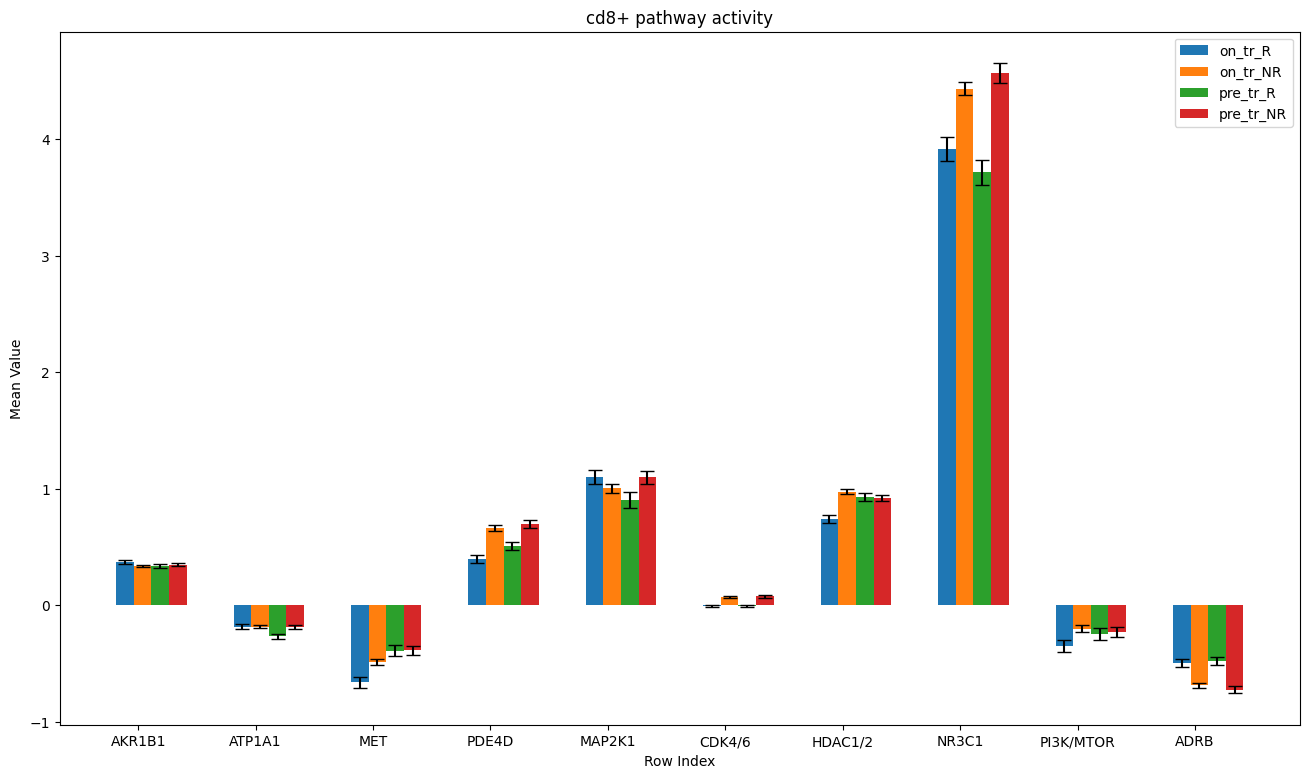

In [91]:
r3meanR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_R)))].mean(axis = 1)
r3meanNR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_NR)))].mean(axis = 1)
r3seR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_R)))].std(axis = 1) / np.sqrt(result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_R)))].shape[1])
r3seNR = result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_NR)))].std(axis = 1) / np.sqrt(result_con3[list(set(list(result_con3.columns)).intersection(set(IDs_NR)))].shape[1])

r4meanR = result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other)))].mean(axis = 1)
r4meanNR = result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other1)))].mean(axis = 1)
r4seR = result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other)))].std(axis = 1) / np.sqrt(result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other)))].shape[1])
r4seNR = result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other1)))].std(axis = 1) / np.sqrt(result_con4[list(set(list(result_con4.columns)).intersection(set(IDs_other1)))].shape[1])

# Plot the means with error bars
fig, ax = plt.subplots(figsize=(16, 9))

# Number of rows
index = np.arange(len(result_con3))
bar_width = 0.15

# Bar plots for the first DataFrame
bars1 = ax.bar(index, r3meanR, bar_width, yerr=r3seR, capsize=5, label='on_tr_R')

# Bar plots for the second DataFrame (offset by bar_width)
bars2 = ax.bar(index + bar_width, r3meanNR, bar_width, yerr=r3seNR, capsize=5, label='on_tr_NR')

bars3 = ax.bar(index + bar_width + bar_width, r4meanR, bar_width, yerr=r4seR, capsize=5, label='pre_tr_R')
bars4 = ax.bar(index + 3 * bar_width, r4meanNR, bar_width, yerr=r4seNR, capsize=5, label='pre_tr_NR')

# Adding labels and title
ax.set_xlabel('Row Index')
ax.set_ylabel('Mean Value')
ax.set_title('cd8+ pathway activity')
ax.set_xticks(index + 3* bar_width / 4)
ax.set_xticklabels(result_con3.index)
ax.legend()

plt.savefig(os.path.join(bmra_path, "pathway_activity/cd8_activity.png"), dpi = 300)
plt.show()

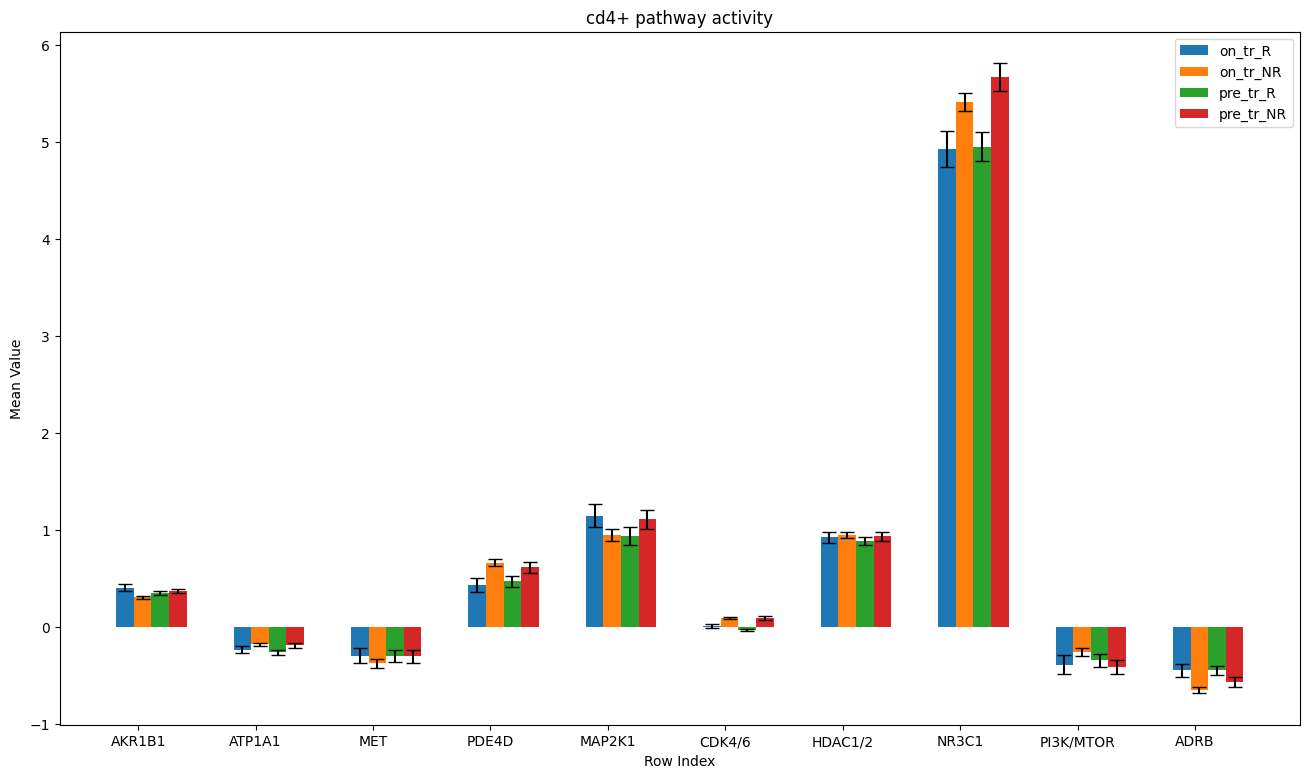

In [92]:
r5meanR = result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_R)))].mean(axis = 1)
r5meanNR = result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_NR)))].mean(axis = 1)
r5seR = result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_R)))].std(axis = 1) / np.sqrt(result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_R)))].shape[1])
r5seNR = result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_NR)))].std(axis = 1) / np.sqrt(result_con5[list(set(list(result_con5.columns)).intersection(set(IDs_NR)))].shape[1])

r6meanR = result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other)))].mean(axis = 1)
r6meanNR = result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other1)))].mean(axis = 1)
r6seR = result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other)))].std(axis = 1) / np.sqrt(result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other)))].shape[1])
r6seNR = result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other1)))].std(axis = 1) / np.sqrt(result_con6[list(set(list(result_con6.columns)).intersection(set(IDs_other1)))].shape[1])

# Plot the means with error bars
fig, ax = plt.subplots(figsize=(16, 9))

# Number of rows
index = np.arange(len(result_con3))
bar_width = 0.15

# Bar plots for the first DataFrame
bars1 = ax.bar(index, r5meanR, bar_width, yerr=r5seR, capsize=5, label='on_tr_R')

# Bar plots for the second DataFrame (offset by bar_width)
bars2 = ax.bar(index + bar_width, r5meanNR, bar_width, yerr=r5seNR, capsize=5, label='on_tr_NR')

bars3 = ax.bar(index + bar_width + bar_width, r6meanR, bar_width, yerr=r6seR, capsize=5, label='pre_tr_R')
bars4 = ax.bar(index + 3 * bar_width, r6meanNR, bar_width, yerr=r6seNR, capsize=5, label='pre_tr_NR')

# Adding labels and title
ax.set_xlabel('Row Index')
ax.set_ylabel('Mean Value')
ax.set_title('cd4+ pathway activity')
ax.set_xticks(index + 3* bar_width / 4)
ax.set_xticklabels(result_con3.index)
ax.legend()

plt.savefig(os.path.join(bmra_path, "pathway_activity/cd4_activity.png"), dpi = 300)
plt.show()